**cml1 - Immobilienrechner**

# Klassifikation des Objekttyps

Das Ziel dieses Notebooks ist es, der Typ des Objekts anhand verschiedener Modelle zu klassifizieren. Die verwendeten Daten stammen aus dem `datawrangling.ipynb` Notebook, wobei die Daten gesäubert und aufbereitet wurden.

## Metriken

In der Welt der Datenanalyse und des maschinellen Lernens sind Metriken unerlässlich, um die Leistungsfähigkeit und Genauigkeit von Klassifikationsmodellen zu bewerten. Sie ermöglichen es uns, die Effektivität unserer Modelle objektiv zu messen und Bereiche für Verbesserungen zu identifizieren. Im Folgenden werden einige der wichtigsten Metriken vorgestellt, die üblicherweise zur Bewertung von Klassifikationsmodellen verwendet werden:

### Accuracy

Die Accuracy ist ein Mass für den Gesamtanteil der korrekt klassifizierten Objekte im Verhältnis zur Gesamtanzahl der Objekte. Sie ist besonders hilfreich in Situationen, in denen die Klassen gleichmässig verteilt sind. In Situationen mit unausgewogenen Klassenverteilungen, wo es wichtig ist, die Minderheitsklasse korrekt zu erkennen, kann der F1-Score daher eine bessere Einschätzung der Modellleistung bieten als die reine Genauigkeit.

<div align="center">

$$
Accuracy = \frac{TP + TN}{TP + TN + FP + FN}
$$

</div>

### Precision

Die Precision bewertet, wie genau die Vorhersagen des Modells sind, indem sie misst, welcher Anteil der Objekte, die als zu einer bestimmten Klasse gehörig vorhergesagt wurden, tatsächlich zu dieser Klasse gehören. Diese Metrik ist besonders wichtig in Szenarien, wo die Kosten für falsch positive Ergebnisse hoch sind.

<div align="center">

$$
Precision = \frac{TP}{TP + FP}
$$

</div>

### Recall

Der Recall gibt an, welcher Anteil der tatsächlichen Objekte einer Klasse vom Modell korrekt identifiziert wurde. Diese Metrik ist kritisch in Fällen, in denen das Übersehen von tatsächlichen Fällen schwerwiegende Konsequenzen hat.

<div align="center">

$$
Recall = \frac{TP}{TP + FN}
$$

</div>


### F1-Score

Der F1-Score ist der harmonische Mittelwert von Precision und Recall und bietet eine Balance zwischen diesen beiden Metriken. Er ist besonders nützlich, wenn ein Ausgleich zwischen Precision und Recall erforderlich ist. Der F1-Score reicht von 0 bis 1, wobei 1 für perfekte Präzision und Recall steht.

<div align="center">

$$
F1 = 2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}
$$

</div>


### Konfusionsmatrix 

Die Konfusionsmatrix bietet eine detaillierte Darstellung der korrekten und falschen Vorhersagen für jede Klasse und ist ein nützliches Werkzeug zur visuellen Analyse der Leistung eines Klassifikationsmodells.

<div align="center">

$$
Confusion\ Matrix = \begin{bmatrix} TN & FP \\ FN & TP \end{bmatrix}
$$

</div>

- **True Positive (TP)**: Ein Objekt wurde als positiv vorhergesagt und ist tatsächlich positiv.
- **True Negative (TN)**: Ein Objekt wurde als negativ vorhergesagt und ist tatsächlich negativ.
- **False Positive (FP)**: Ein Objekt wurde als positiv vorhergesagt, ist aber tatsächlich negativ.
- **False Negative (FN)**: Ein Objekt wurde als negativ vorhergesagt, ist aber tatsächlich positiv.


### ROC

Die ROC-Kurve (Receiver Operating Characteristic) ist eine grafische Darstellung der Leistung eines binären Klassifikators, der die Trade-offs zwischen den wahren positiven Raten (TPR) und den falsch positiven Raten (FPR) veranschaulicht. Sie wird häufig verwendet, um die Leistungsfähigkeit eines Klassifikationsmodells zu bewerten, wenn die Klassen ungleichmässig verteilt sind.

<div align="center">

$$
TPR = \frac{TP}{TP + FN}
$$

$$
FPR = \frac{FP}{FP + TN}
$$

</div>

### AUC-ROC (Area Under the Receiver Operating Characteristic Curve)

Die AUC (Area Under Curve) misst die gesamte zweidimensionale Fläche unterhalb der gesamten ROC-Kurve und bietet damit ein aggregiertes Mass der Leistung über alle möglichen Klassifikationsschwellen hinweg. Der ROC-AUC-Wert reicht von 0 bis 1, wobei 1 für ein perfektes Modell und 0.5 für ein Modell steht, das nicht besser ist als eine zufällige Schätzung. Eine hohe AUC-ROC deutet darauf hin, dass das Modell eine gute Trennung zwischen den Klassen erreicht, was bei ungleicher Klassenverteilung entscheidend ist.


### Matthews Korrelationskoeffizient (MCC)

Der Matthews Korrelationskoeffizient ist eine Metrik, die die Qualität der binären (zwei Klassen) Klassifikationen bewertet. Er ist besonders nützlich, wenn die Klassen ungleichmässig verteilt sind. Der MCC reicht von -1 bis +1. Ein Koeffizient von +1 steht für eine perfekte Vorhersage, 0 ist nicht besser als eine zufällige Vorhersage, und -1 bedeutet, dass Vorhersage und Beobachtung völlig auseinanderklaffen.

<div align="center">

$$
MCC = \frac{TP \cdot TN - FP \cdot FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

</div>

## Metrik Auswahl

Bei der Bewertung von Klassifikationsmodellen mit einer ungleichen Verteilung der Immobilienarten sind bestimmte Metriken besonders aussagekräftig und sollten daher bevorzugt verwendet werden. In solchen Szenarien ist die herkömmliche Genauigkeitsmetrik (Accuracy) oft irreführend, da sie die Leistung des Modells in Bezug auf die überwiegende Klasse überbetont und die Minderheitenklasse vernachlässigt.

Wir haben uns also entschieden, uns auf diese drei spezifische Metriken zu konzentrieren, um die Leistung unserer Klassifikationsmodelle zu bewerten:

Eine der wichtigsten Metriken in diesem Kontext ist der `F1-Score`. Da er den harmonischen Mittelwert von Precision und Recall darstellt, bietet der F1-Score eine ausgewogene Bewertung der Modellleistung, indem er sowohl die Fähigkeit des Modells berücksichtigt, tatsächlich positive Fälle korrekt zu identifizieren (Recall), als auch die Genauigkeit seiner positiven Vorhersagen (Precision). Diese Balance ist besonders wichtig in Situationen, in denen sowohl die Vermeidung von falsch positiven als auch von falsch negativen Ergebnissen von Bedeutung ist.

Für eine umfassendere Bewertung ist auch die `Area Under the Receiver Operating Characteristic Curve (AUC-ROC)` von grossem Wert. Die AUC-ROC misst, wie gut das Modell zwischen den Klassen unterscheidet, unabhängig von der Schwellenwertwahl. 

Zusätzlich ist der `Matthews Korrelationskoeffizient (MCC)` eine robuste Metrik, die auch bei stark ungleich verteilten Daten effektiv ist. Der MCC berücksichtigt alle vier Werte der Konfusionsmatrix (TP, FP, TN, FN) und liefert einen ausgewogenen Score, der sowohl die Stärken als auch die Schwächen des Modells in Bezug auf alle Aspekte der Klassifikation widerspiegelt.

## Fehlerabschätzung für neue Daten

Um eine gute Abschätzung des Fehlers für neue Daten zu erhalten, insbesondere in Kontexten wie maschinellem Lernen und statistischer Modellierung, gibt es verschiedene wichtige Aspekte, die berücksichtigt werden sollten:

**1. Vermeidung von Overfitting:** Um Overfitting zu vermeiden, muss ichergestellt werden, dass das Modell nicht nur auf den Trainingsdaten gut funktioniert, sondern auch auf neuen, unbekannten Daten. 

**2. Cross-Validation:** Kreuzvalidierung ist eine wichtige Methode, um eine bessere Schätzung der Modellleistung zu erhalten. 

**3. Ausgewogenheit der Klassen:** Ausserdem sollte darauf geachtet werden, dass falls der Datensatz eine starke Unausgewogenheit in den Klassen aufweist, sollte man die Leistung des Modells anhand der Metriken `F1-Score`, `AUC-ROC` und `MCC` bewerten, da diese Metriken die Leistung des Modells in Bezug auf die Minderheitenklasse besser widerspiegeln.

**4. Feature-Importance:** Schliesslich sollte analysiert werden, welche Merkmale am meisten zur Klassifizierung beitragen, um die Feature-Importance zu verstehen.

## Daten laden und betrachten

In [662]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Imputer
from sklearn.impute import KNNImputer

# Modelle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score, matthews_corrcoef, roc_auc_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

In [663]:
df = pd.read_csv('../../data/immo_data_clean.csv', low_memory=False)
print("Anzahl der Zeilen: ", df.shape[0])
print("Anzahl der Spalten: ", df.shape[1])

Anzahl der Zeilen:  21466
Anzahl der Spalten:  57


Da es in diesem Notebook um die Art der Immobilien geht, wollen wir nochmals einen Blick auf deren Verteilung werfen.

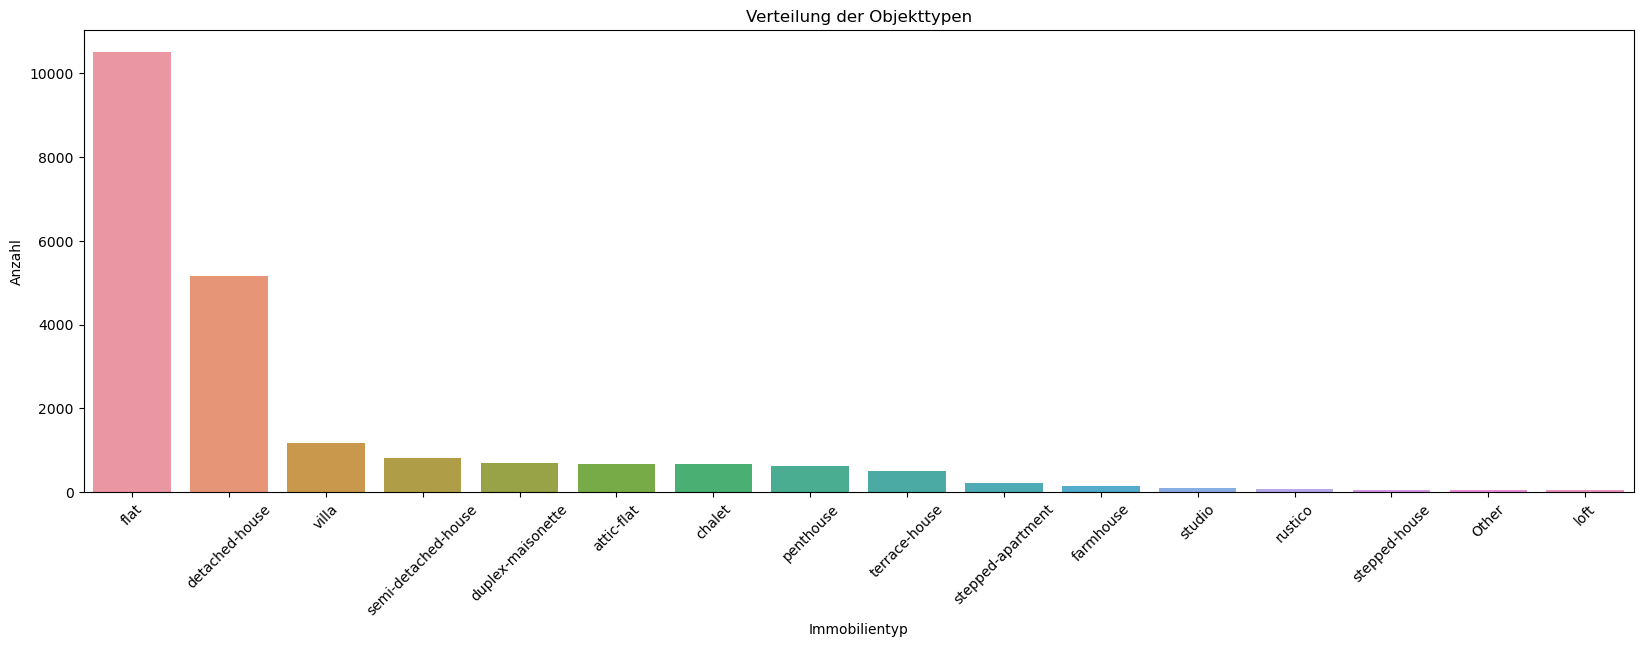

In [664]:
plt.figure(figsize=(20,6))
sns.countplot(x='type_unified', data=df, order=df['type_unified'].value_counts().index)
plt.title('Verteilung der Objekttypen')
plt.xlabel('Immobilientyp')
plt.ylabel('Anzahl')
plt.xticks(rotation=45)
plt.show()

Das Diagramm zeigt eine sehr ungleichmässige Verteilung der Immobilientypen. `flat` ist die häufigste Kategorie, gefolgt von `detached house`, wobei die Häufigkeit der anderen Typen deutlich abnimmt. Eine solche Verteilung bedeutet folgendes im Sinne eines Klassifikationsmodells:

1. **Modell Bias**: Das Modell kann zu Vorhersagen für die Mehrheitsklassen (`flat` und `detached house`) neigen, da es mehr Datenpunkte gibt, aus denen das Modell für diese Klassen lernen kann.

2. **Performance Metriken**: Die Standardgenauigkeit ist möglicherweise keine gute Leistungskennzahl, da die Vorhersage von überwiegend `flat` zwar eine höhere Genauigkeit, aber einen geringen Modellnutzen ergeben könnte. Metriken, die einen besseren Einblick in die klassenspezifische Leistung geben, wie `F1-Score`, `AUC-ROC` oder der `Matthews-Korrelationskoeffizient`, wären besser geeignet.

3. **Resampling-Techniken**: Techniken wie das Oversampling der Minderheitsklassen, das Undersampling der Mehrheitsklassen oder die Verwendung synthetischer Daten (wie SMOTE) können notwendig sein, um ein gut verallgemeinertes Modell zu trainieren.

4. **Klassengewichte**: Die Anpassung der Klassengewichte im Modell könnte dazu beitragen, die unausgewogenen Daten zu kompensieren, indem den Minderheitsklassen beim Training mehr Bedeutung beigemessen wird.

5. **Modellbewertung**: Das Modell sollte anhand von Metriken bewertet werden, die das Klassenungleichgewicht berücksichtigen, wie z. B. der `ROC-AUC-Score`, um sicherzustellen, dass es in allen Klassen und nicht nur in der Mehrheitsklasse gute Leistungen erbringt.

## Daten vorbereiten

Hier bereiten wir die Daten für die Modellierungen vor. Die Vorbereitung der Daten erfolgt in den gleichen Schritten wie bei der Aufgabe 2.2 (Bestmögliches Regressionsmodell).

1. Spalten löschen
2. Kategorische und numerische Spalten trennen
3. Kategorische Spalten mit `LabelEncoder` kodieren. 
4. Ausreisser mittels Quantile entfernen

In [665]:
df = df.drop(columns=[
    "Zip",
    "Availability_Categorized",

    "Floor_unified",

    "gde_politics_bdp",
    "gde_politics_cvp",
    "gde_politics_evp",
    "gde_politics_fdp",
    "gde_politics_glp",
    "gde_politics_gps",
    "gde_politics_rights",
    "gde_politics_sp",
    "gde_politics_svp",

    "distanceToTrainStation",

    "NoisePollutionRailwayL", "NoisePollutionRailwayM", "NoisePollutionRailwayS",
    "NoisePollutionRoadL", "NoisePollutionRoadM", "NoisePollutionRoadS",
    "PopulationDensityL", "PopulationDensityM", "PopulationDensityS",
    "RiversAndLakesL", "RiversAndLakesM", "RiversAndLakesS",
    "WorkplaceDensityL", "WorkplaceDensityM", "WorkplaceDensityS",
    "ForestDensityL", "ForestDensityM", "ForestDensityS",
])

In [666]:
def preprocess_dataframe(df):
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    label_encoders = {}

    for col in categorical_columns:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col])
        label_encoders[col] = encoder

    return df, numerical_columns, label_encoders


def remove_outliers(df, numerical_columns):
    df_processed = df.copy()

    quantiles_1 = df_processed[numerical_columns].quantile(0.015)
    quantiles_99 = df_processed[numerical_columns].quantile(0.985)

    for column in numerical_columns:
        condition = (df_processed[column] < quantiles_1[column]) | (df_processed[column] > quantiles_99[column])
        df_processed.loc[condition, column] = None

    return df_processed

# Preprocess the dataframe
df, num_cols_df, label_encoders = preprocess_dataframe(df)

# Remove outliers
df = remove_outliers(df, num_cols_df)

df = df.dropna(subset=['type_unified'], axis=0)

## Train Test Split

Nun werden die Daten in 80% Trainings- und 20% Testdaten aufgeteilt. Die Zielvariable ist `type_unified` und wird ebenfalls getrennt.

In [667]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

X_train = train.drop(columns=['type_unified'])
y_train = train['type_unified']

X_test = test.drop(columns=['type_unified'])
y_test = test['type_unified']

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (17172, 25)
y_train shape:  (17172,)
X_test shape:  (4294, 25)
y_test shape:  (4294,)


## Imputation

Für die Imputation der fehlenden Werte verwenden wir den `KNNImputer` von `sklearn`. Dieser Imputer verwendet die k-Nearest Neighbors Methode, um fehlende Werte zu imputieren. In unserem Fall verwenden wir die 5 nächsten Nachbarn.

In [668]:
cols = X_train.columns

imputer = KNNImputer(n_neighbors=5)

X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=cols)
X_test = pd.DataFrame(imputer.transform(X_test), columns=cols)

## Standardisierung

Hier verwenden wir den `StandardScaler` von `sklearn`, um die Daten zu standardisieren. Dieser Skalierer standardisiert Merkmale, indem er den Mittelwert auf 0 und die Standardabweichung auf 1 setzt. Wir berücksichtigen dabei nur die numerischen Spalten.

In [669]:
scaler = StandardScaler()

X_train[num_cols_df] = scaler.fit_transform(X_train[num_cols_df])
X_test[num_cols_df] = scaler.transform(X_test[num_cols_df])

## Scorers

Hier definieren wir unsere `Scorers` für die Modellbewertung. Wie oben bereits erwähnt verwenden wir die Metriken `F1-Score`, `ROC-AUC-Score` und `Matthews-Korrelationskoeffizient`.

In [670]:
scorers = {
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr'),
    'f1': make_scorer(f1_score, average='weighted'),
    'mcc': make_scorer(matthews_corrcoef)
}

for name, scorer in scorers.items():
    print(name, scorer)

roc_auc make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr)
f1 make_scorer(f1_score, average=weighted)
mcc make_scorer(matthews_corrcoef)


## Modellierung

Wir werden drei verschiedene Modelle verwenden, um die Immobilienobjekte zu klassifizieren:

1. Logistic Regression
2. Random Forest Classifier
3. Hist Gradient Boosting Classifier

Um das Verfahren für alle drei Modelle zu beschreiben, hier eine detaillierte Erklärung des gesamten Modellierungsprozesses:

**Definition der Parameter-Grids:** Für jedes Modell wird ein separates `param_grid` definiert, das die zu optimierenden Hyperparameter enthält. Diese Grids variieren je nach den spezifischen Hyperparametern, die wir für jedes Modell als relevant erachten.

**Durchführung des Grid Search:** Mit `GridSearchCV` wird für jedes Modell und jede Bewertungsmetrik ein Prozess durchgeführt. Dabei werden verschiedene Kombinationen der Parameter aus den jeweiligen `param_grids` ausprobiert, um die beste Kombination gemäss der jeweiligen Bewertungsmetrik zu finden. Eine 5-fache Kreuzvalidierung (`cv=5`) wird verwendet, um die Modellleistung zu bewerten.

**Modelltraining und Evaluierung:** Jedes Modell wird mit den verschiedenen Parameterkombinationen trainiert. Nach dem Grid-Search Prozess wird das beste Modell für jede Metrik identifiziert.

**Speichern der Ergebnisse:** Die Ergebnisse, einschliesslich der besten Parameter, der erzielten Scores und der Vorhersagen, werden für jede Metrik in einem separaten Dictionary für jedes Modell gespeichert. Für den `roc_auc` Score werden die Wahrscheinlichkeiten und die Klassen-Vorhersagen gespeichert, während für andere Metriken die direkten Vorhersagen gespeichert werden.

**Ergebnisanalyse:** Nach Abschluss der Grid-Search Prozesse für alle Modelle werden die gespeicherten Ergebnisse analysiert mittels Confusion Matrix und Classification Report, um die Leistung der Modelle für das Identifizieren der Immobilienobjekte zu vergleichen.

### Logistic Regression

Die logistische Regression ist ein lineares Klassifikationsmodell, das zur Vorhersage binärer oder multiklassiger Ergebnisse verwendet wird. Es modelliert die Wahrscheinlichkeit des Eintretens eines bestimmten Ereignisses als Funktion der unabhängigen Variablen. Es verwendet die logistische Funktion (auch Sigmoid-Funktion genannt), um Wahrscheinlichkeiten zu schätzen und eine Entscheidungsgrenze zu ziehen.

[scikit-learn.org - Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

#### Hyperparameter-Tuning mittels verschiedener Metriken

In [671]:
log_reg = LogisticRegression(random_state=42, solver='liblinear')

param_grid = {
    'C': [0.001, 0.01, 0.1, 0.25, 0.5, 1],
    'penalty': ['l2'],
    'max_iter': [100, 200, 300,],
    'class_weight': [None, 'balanced']
}

results_log_reg = {}

for scorer_name, scorer in scorers.items():
    print(f"Optimierung mit {scorer_name}")

    grid_search_log_reg = GridSearchCV(
        log_reg,
        param_grid,
        scoring=scorer,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search_log_reg.fit(X_train, y_train)
    best_model_log_reg = grid_search_log_reg.best_estimator_

    # Unterschiedliche Behandlung von ROC-AUC
    if scorer_name == 'roc_auc':
        probabilities = best_model_log_reg.predict_proba(X_test)
        predictions_roc_auc = np.argmax(probabilities, axis=1)
        score_log_reg = roc_auc_score(y_test, probabilities, multi_class='ovr')
        results_log_reg[scorer_name] = {
            'Beste Parameter': grid_search_log_reg.best_params_,
            'Score': score_log_reg,
            'Probabilities': probabilities,
            'Predictions': predictions_roc_auc
        }
    else:
        predictions = best_model_log_reg.predict(X_test)
        score_log_reg = scorer(best_model_log_reg, X_test, y_test)

        results_log_reg[scorer_name] = {
            'Beste Parameter': grid_search_log_reg.best_params_,
            'Score': score_log_reg,
            'Predictions': predictions
        }

Optimierung mit roc_auc
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Optimierung mit f1
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Optimierung mit mcc
Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [672]:
for scorer_name, result in results_log_reg.items():
    print(f"\nErgebnisse für {scorer_name}:")
    print("Beste Parameter:", result['Beste Parameter'])
    print("Score:", result['Score'])


Ergebnisse für roc_auc:
Beste Parameter: {'C': 1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2'}
Score: 0.7693743139720941

Ergebnisse für f1:
Beste Parameter: {'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2'}
Score: 0.5261614635684725

Ergebnisse für mcc:
Beste Parameter: {'C': 0.25, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2'}
Score: 0.3992779917960108


1. **ROC AUC (Receiver Operating Characteristic Area Under Curve) Wert: 0.769**
    - Ein Wert von 0.769 ist recht gut und deutet darauf hin, dass das Modell gut in der Lage ist, zwischen den verschiedenen Klassen in Ihrem Datensatz zu unterscheiden.
    - In einer Mehrklassenumgebung wird diese Punktzahl über alle Klassen hinweg gewichtet und gibt die Gesamteffektivität des Modells über alle Kategorien hinweg an.

2. **F1-Score: 0.526**
    - Ein Wert von 0.526 ist mässig niedrig.
    - Dieser niedrigere Wert im Vergleich zum ROC AUC könnte darauf hindeuten, dass das Modell zwar die positive Klasse besser als die negative Klasse einstuft, aber möglicherweise nicht so effektiv bei der genauen Identifizierung echter Positiver ist oder eine erhebliche Anzahl falsch positiver oder falsch negativer Ergebnisse erzeugt.

3. **Matthews Korrelationskoeffizient: 0.399**
    - Ein Wert von 0.399 ist zwar positiv, aber relativ niedrig. Dies deutet darauf hin, dass das Modell eine bescheidene Qualität der Vorhersagen aufweist.
    - MCC gilt als ausgewogenes Mass, auch wenn die Klassen sehr unterschiedlich gross sind, so dass dieser Wert besonders nützlich ist, wenn der Datensatz unausgewogen ist.

Für die weitere Analysen des Logistischen Regressionsmodells haben wir uns entschieden, die `ROC AUC` Metrik zu verwenden, da diese Metrik die beste Leistung zu liefern scheint. 

#### Confusion Matrix

Für die Konfusionsmatrix müssen wir die Vorhersagen für den `roc_auc` Score auswählen.

In [673]:
y_pred_log_reg = results_log_reg['roc_auc']['Predictions']

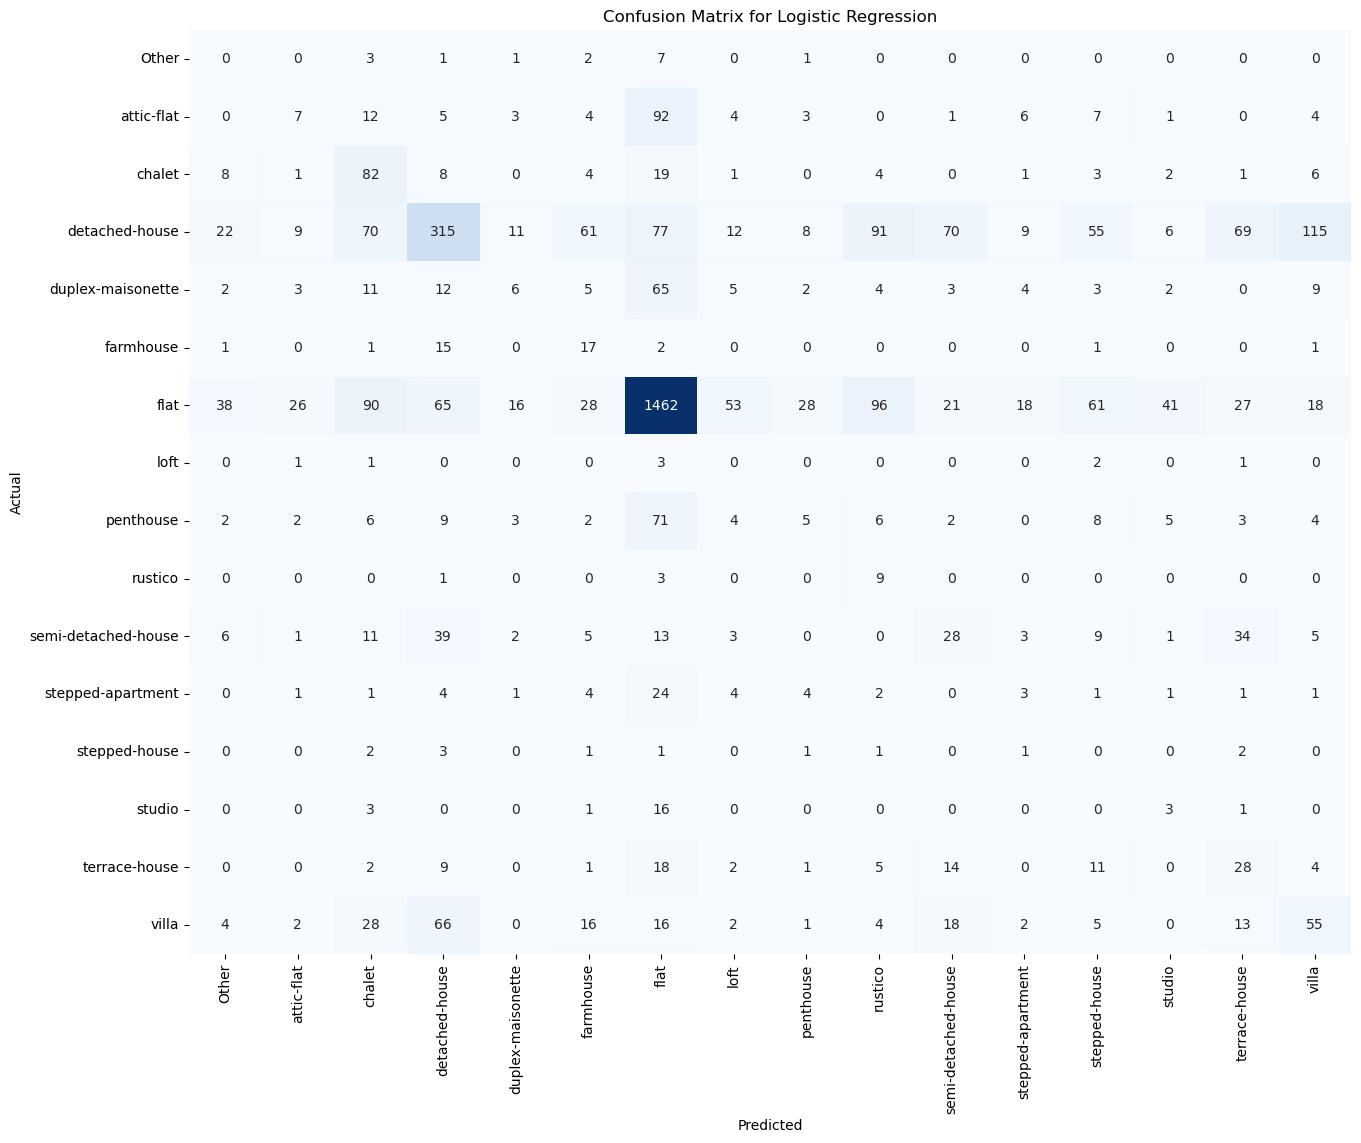

In [674]:
labels = label_encoders['type_unified'].classes_

cm = confusion_matrix(y_test, y_pred_log_reg)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

#### Classification Report

In [675]:
print(classification_report(y_test, y_pred_log_reg, target_names=labels, zero_division=0))

                     precision    recall  f1-score   support

              Other       0.00      0.00      0.00        15
         attic-flat       0.13      0.05      0.07       149
             chalet       0.25      0.59      0.35       140
     detached-house       0.57      0.32      0.41      1000
  duplex-maisonette       0.14      0.04      0.07       136
          farmhouse       0.11      0.45      0.18        38
               flat       0.77      0.70      0.74      2088
               loft       0.00      0.00      0.00         8
          penthouse       0.09      0.04      0.05       132
            rustico       0.04      0.69      0.08        13
semi-detached-house       0.18      0.17      0.18       160
  stepped-apartment       0.06      0.06      0.06        52
      stepped-house       0.00      0.00      0.00        12
             studio       0.05      0.12      0.07        24
      terrace-house       0.16      0.29      0.20        95
              villa    

#### Interpretation der Ergebnisse

Anhand der Konfusions-Matrix und Klassifikationsbericht können wir sehen, dass das Modell Verbesserungsbedarf hat, um die Klassifizierung der Immobilienobjekte zu verbessern. Wenn wir die Diagonale der Konfusionsmatrix betrachten, können wir sehen, dass die Immobilienobjekte hauptsächlich nur als die häufigsten Klassen (`flat` und `detached-house`) klassifiziert werden. Die anderen Klassen werden nicht gut erkannt.

Auffällig ist das Immobilienobjekt `chalet`, welches nur 140 mal vorkommt, im Vergleich zu den anderen Klassen recht gut klassifiziert wird. Was auch ins Auge sticht, ist dass `penthouse` mit 132 Fällen, nur 5 mal richtig klassifiziert wurde. Dies liegt wahrscheinlich daran, dass die Klasse `penthouse` sehr ähnlich zu `flat` ist und somit das Modell diese beiden Klassen nicht gut unterscheiden kann. 

### Random Forest Classifier

Der Random Forest Classifier ist ein Ensemble-Lernmodell, das aus einer Menge von Entscheidungsbäumen besteht. Es erstellt mehrere Entscheidungsbäume auf zufällig ausgewählten Teilmengen der Trainingsdaten und kombiniert ihre Vorhersagen, um Overfitting zu reduzieren und genauere Vorhersagen zu erzielen. Es eignet sich gut für Klassifikationsaufgaben.

[scikit-learn.org - Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

#### Hyperparameter-Tuning mittels verschiedener Metriken

In [686]:
rf = RandomForestClassifier(random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 500], 
    'max_depth': [None, 6, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
}

results_rf = {}

for scorer_name, scorer in scorers.items():
    print(f"Optimierung mit {scorer_name}")

    grid_search_rf = GridSearchCV(
        rf,
        param_grid_rf,
        scoring=scorer,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search_rf.fit(X_train, y_train)
    best_model_rf = grid_search_rf.best_estimator_

    # Unterschiedliche Behandlung basierend auf dem Scorer
    if scorer_name == 'roc_auc':
        probabilities = best_model_rf.predict_proba(X_test)
        y_pred_roc_auc = np.argmax(probabilities, axis=1)
        score_rf = roc_auc_score(y_test, probabilities, multi_class='ovr')
        results_rf[scorer_name] = {
            'Beste Parameter': grid_search_rf.best_params_,
            'Score': score_rf,
            'Probabilities': probabilities,
            'Predictions': y_pred_roc_auc
        }
    else:
        predictions = best_model_rf.predict(X_test)
        if scorer_name == 'mcc':
            score_rf = matthews_corrcoef(y_test, predictions)
        else:
            score_rf = f1_score(y_test, predictions, average='weighted')

        results_rf[scorer_name] = {
            'Beste Parameter': grid_search_rf.best_params_,
            'Score': score_rf,
            'Predictions': predictions
        }

Optimierung mit roc_auc
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Optimierung mit f1
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Optimierung mit mcc
Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [687]:
for scorer_name, result in results_rf.items():
    print(f"\nErgebnisse für {scorer_name}:")
    print("Beste Parameter:", result['Beste Parameter'])
    print("Score:", result['Score'])


Ergebnisse für roc_auc:
Beste Parameter: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Score: 0.8767470341845481

Ergebnisse für f1:
Beste Parameter: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Score: 0.6682668566782995

Ergebnisse für mcc:
Beste Parameter: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Score: 0.555019282610499


1. **ROC AUC-Wert: 0.876**: Zeigt eine gute Fähigkeit an, zwischen den Klassen zu unterscheiden. Um einiges effektiver als das Modell der logistischen Regression.

2. **F1 Ergebnis: 0.668**: Dies ist ebenfalls eine Verbesserung gegenüber dem logistischen Regressionsmodell und deutet auf ein besseres Gleichgewicht zwischen Präzision und Recall hin.

3. **MCC: 0.555**: Eine deutliche Verbesserung gegenüber dem logistischen Regressionsmodell, was auf eine bessere Gesamtvorhersagequalität hindeutet.

**Gesamtinterpretation:** Das Random-Forest-Modell zeigt im Vergleich zum logistischen Regressionsmodell eine ausgewogene Leistung über alle Metriken hinweg, mit deutlich besseren F1- und MCC-Werten, was auf eine bessere Gesamteffektivität der Klassifizierung hindeutet.

Schauen wir mittels der Konfusionsmatrix und des Klassifikationsberichts etwas genauer hin. Wir werden hierzu die Vorhersagen für den `f1` Score auswählen.

#### Confusion Matrix

In [678]:
y_pred_rf = results_rf['f1']['Predictions']

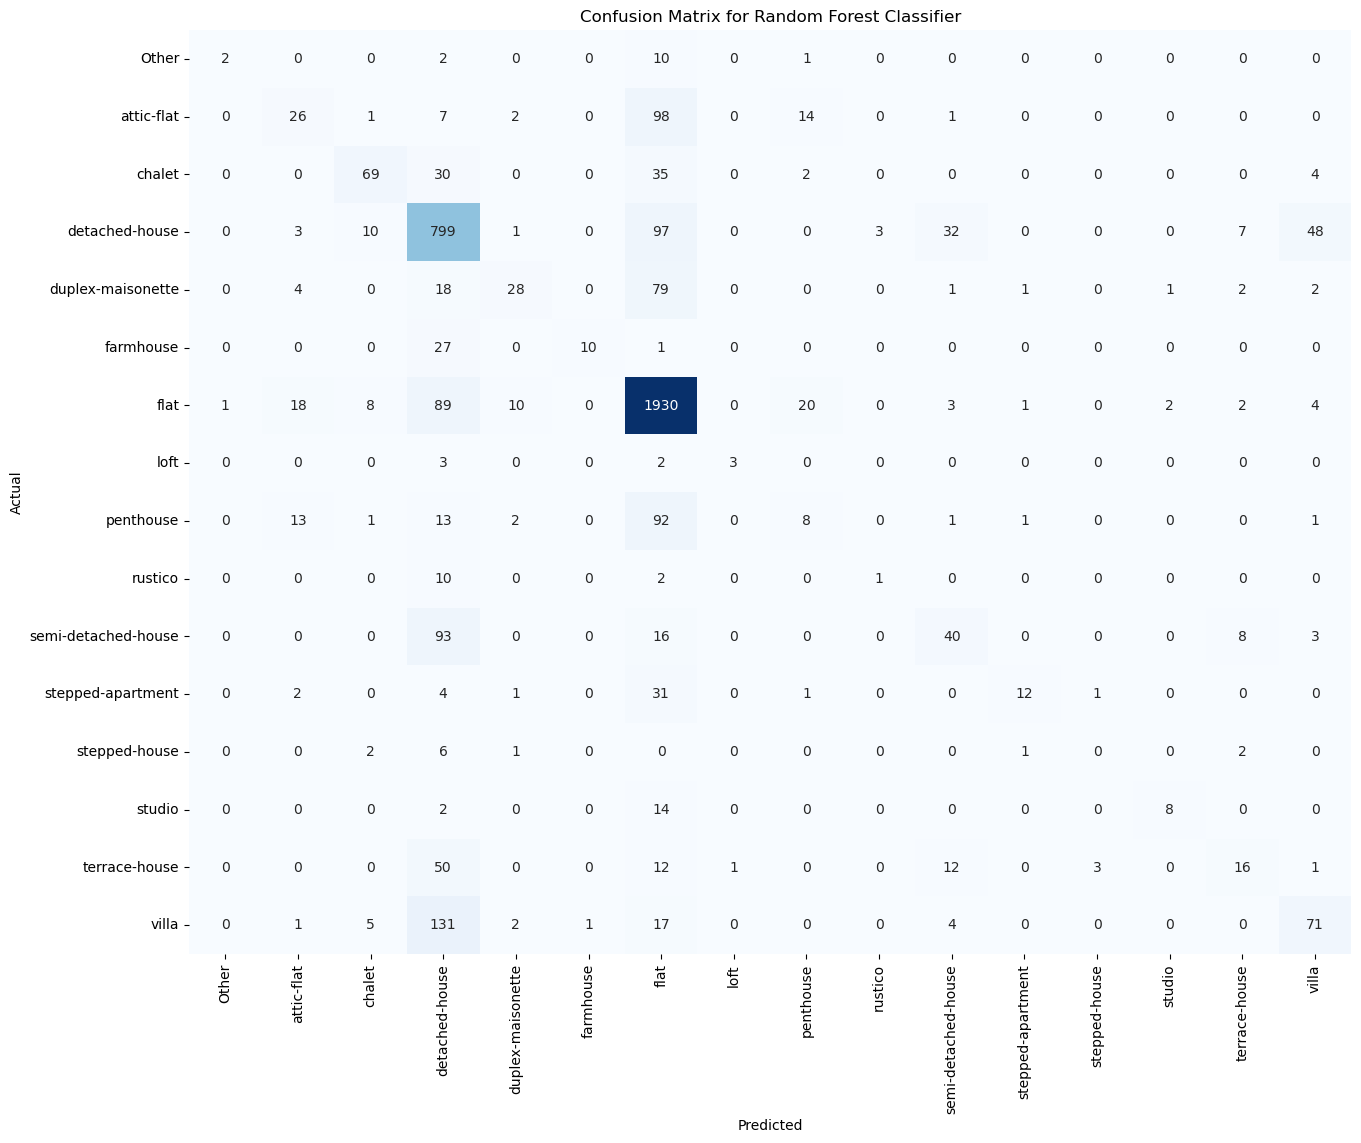

In [679]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

#### Classification Report

In [680]:
print(classification_report(y_test, y_pred_rf, target_names=labels, zero_division=0))

                     precision    recall  f1-score   support

              Other       0.67      0.13      0.22        15
         attic-flat       0.39      0.17      0.24       149
             chalet       0.72      0.49      0.58       140
     detached-house       0.62      0.80      0.70      1000
  duplex-maisonette       0.60      0.21      0.31       136
          farmhouse       0.91      0.26      0.41        38
               flat       0.79      0.92      0.85      2088
               loft       0.75      0.38      0.50         8
          penthouse       0.17      0.06      0.09       132
            rustico       0.25      0.08      0.12        13
semi-detached-house       0.43      0.25      0.31       160
  stepped-apartment       0.75      0.23      0.35        52
      stepped-house       0.00      0.00      0.00        12
             studio       0.73      0.33      0.46        24
      terrace-house       0.43      0.17      0.24        95
              villa    

#### Interpretation der Ergebnisse

Die Analyse des Random Forest Klassifikators zeigt eine gute Gesamtleistung mit einer Genauigkeit von 70%, wobei besonders hohe Werte bei der Klassifizierung der häufigsten Klasse `flat` erreicht werden. Allerdings offenbaren die Ergebnisse auch Schwächen in der Klassifizierung seltenerer Klassen, wie z.B. `stepped-house` oder `penthouse`, was sich in niedrigen Präzisions- und Recall-Werten manifestiert. Die Diskrepanz zwischen dem Macro Average und dem Weighted Average deutet darauf hin, dass das Modell bei weniger häufigen Klassen Verbesserungspotenzial hat.

### Hist Gradient Boosting Classifier

Der Histogram Gradient Boosting Classifier ist ein leistungsstarker Ensemble-Klassifikator, der auf dem Gradienten-Boosting-Algorithmus basiert. Er erstellt eine Kombination von Entscheidungsbäumen, indem er schrittweise Schwachstellen (in diesem Fall Bäume) anpasst, um den Fehler zu minimieren. Dieser Classifier verwendet Histogramm-basierte Techniken, um die Berechnung zu beschleunigen und ist für grosse Datensätze geeignet.

[scikit-learn.org - Histogram Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)

#### Hyperparameter-Tuning mittels verschiedener Metriken

In [681]:
hgb = HistGradientBoostingClassifier(random_state=42)

param_grid_hgb = {
    'learning_rate': [0.01, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 12, 20],
    'l2_regularization': [0, 0.1, 0.5, 1],
    'min_samples_leaf': [20, 30, 50],
}

results_hgb = {}

for scorer_name, scorer in scorers.items():
    print(f"Optimierung mit {scorer_name}")

    grid_search_hgb = GridSearchCV(
        hgb,
        param_grid_hgb,
        scoring=scorer,
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search_hgb.fit(X_train, y_train)
    best_model_hgb = grid_search_hgb.best_estimator_

    # Unterschiedliche Behandlung basierend auf dem Scorer
    if scorer_name == 'roc_auc':
        probabilities = best_model_hgb.predict_proba(X_test)
        y_pred_roc_auc = np.argmax(probabilities, axis=1)
        score_hgb = roc_auc_score(y_test, probabilities, multi_class='ovr')
        results_hgb[scorer_name] = {
            'Beste Parameter': grid_search_hgb.best_params_,
            'Score': score_hgb,
            'Probabilities': probabilities,
            'Predictions': y_pred_roc_auc
        }
    else:
        predictions = best_model_hgb.predict(X_test)
        if scorer_name == 'mcc':
            score_hgb = matthews_corrcoef(y_test, predictions)
        else:
            score_hgb = f1_score(y_test, predictions, average='weighted')

        results_hgb[scorer_name] = {
            'Beste Parameter': grid_search_hgb.best_params_,
            'Score': score_hgb,
            'Predictions': predictions
        }

Optimierung mit roc_auc
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Optimierung mit f1
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Optimierung mit mcc
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [682]:
for scorer_name, result in results_hgb.items():
    print(f"\nErgebnisse für {scorer_name}:")
    print("Beste Parameter:", result['Beste Parameter'])
    print("Score:", result['Score'])


Ergebnisse für roc_auc:
Beste Parameter: {'l2_regularization': 0.5, 'learning_rate': 0.1, 'max_depth': 20, 'max_iter': 100, 'min_samples_leaf': 50}
Score: 0.8584043441758009

Ergebnisse für f1:
Beste Parameter: {'l2_regularization': 1, 'learning_rate': 0.1, 'max_depth': None, 'max_iter': 100, 'min_samples_leaf': 50}
Score: 0.6483233528361109

Ergebnisse für mcc:
Beste Parameter: {'l2_regularization': 1, 'learning_rate': 0.1, 'max_depth': None, 'max_iter': 100, 'min_samples_leaf': 30}
Score: 0.534944787968145


1. **ROC AUC-Wert: 0.858**: Vergleichbar mit dem Random-Forest-Modell, was auf eine gute Klassentrennungsfähigkeit hinweist.

2. **F1 Ergebnis: 0.648**: Ähnlich wie das Random Forest Modell, was auf eine mässige Ausgewogenheit von Präzision und Recall hinweist.

3. **MCC: 0.534**: Etwas niedriger als das Random-Forest-Modell, aber immer noch eine mässige Vorhersagequalität.

**Gesamtinterpretation:** Der Hist Gradient Boosting Classifier zeigt eine ausgewogene Leistung mit einem guten ROC-AUC-Wert und moderaten F1- und MCC-Werten. Er ist konkurrenzfähig mit dem Random-Forest-Modell.

Wir werden nun mit den `mcc` Scores die Konfusionsmatrix und den Klassifikationsbericht erstellen.

#### Confusion Matrix

In [683]:
y_pred_hgb = results_hgb['mcc']['Predictions']

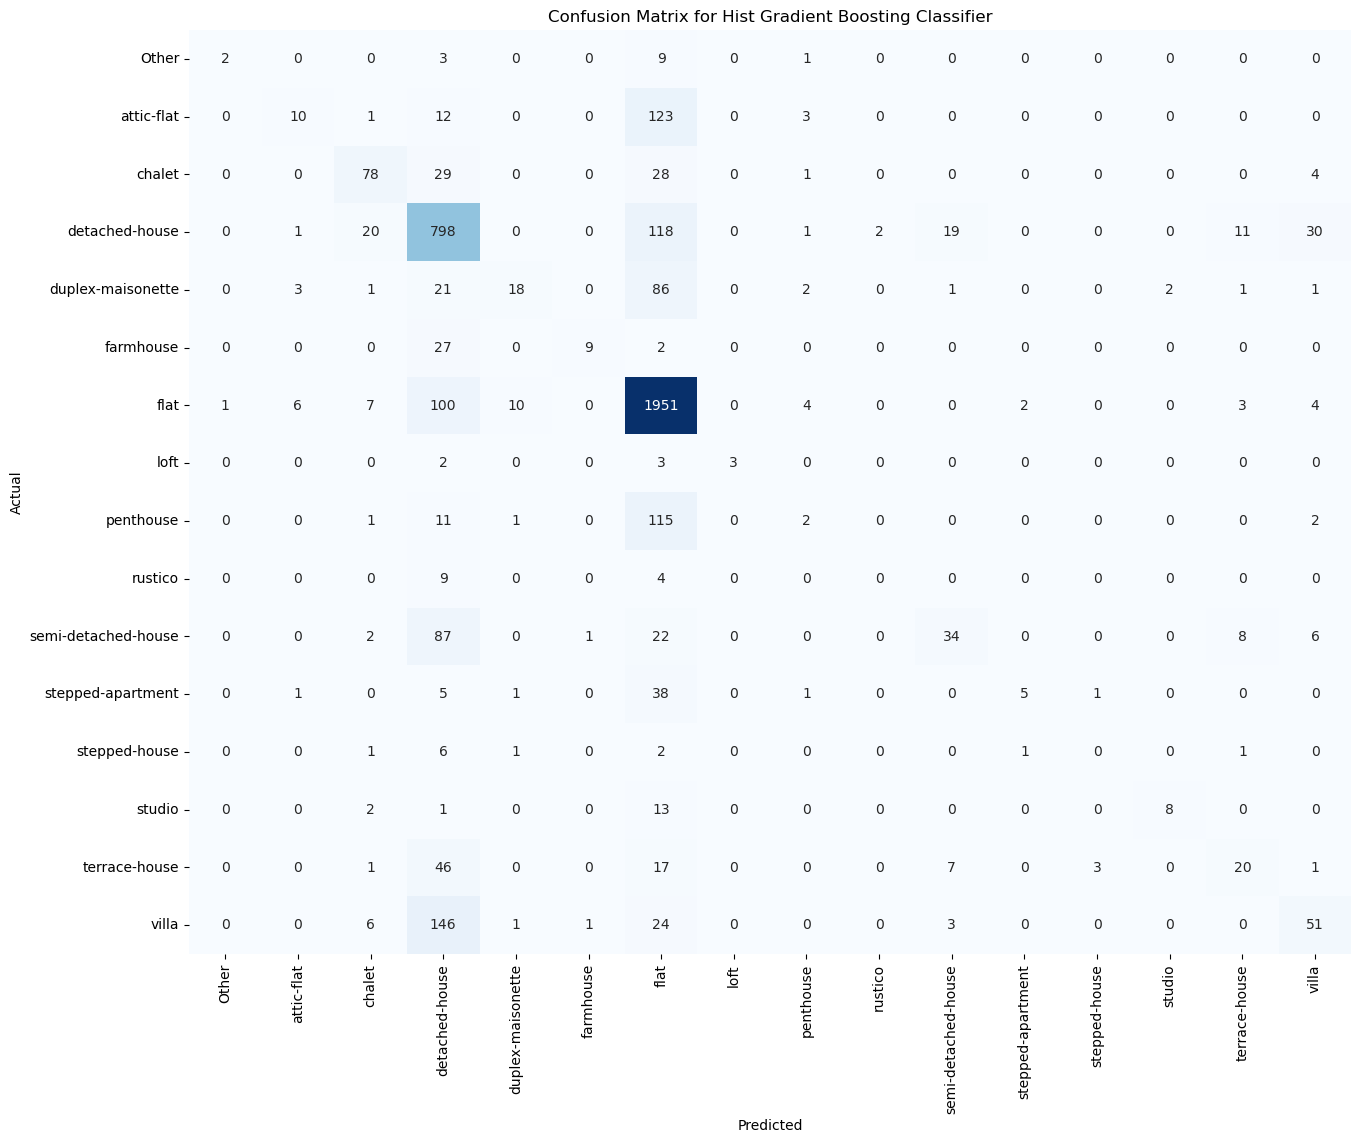

In [684]:
cm = confusion_matrix(y_test, y_pred_hgb)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Hist Gradient Boosting Classifier')
plt.show()

#### Classification Report

In [685]:
print(classification_report(y_test, y_pred_hgb, target_names=labels, zero_division=0))

                     precision    recall  f1-score   support

              Other       0.67      0.13      0.22        15
         attic-flat       0.48      0.07      0.12       149
             chalet       0.65      0.56      0.60       140
     detached-house       0.61      0.80      0.69      1000
  duplex-maisonette       0.56      0.13      0.21       136
          farmhouse       0.82      0.24      0.37        38
               flat       0.76      0.93      0.84      2088
               loft       1.00      0.38      0.55         8
          penthouse       0.13      0.02      0.03       132
            rustico       0.00      0.00      0.00        13
semi-detached-house       0.53      0.21      0.30       160
  stepped-apartment       0.62      0.10      0.17        52
      stepped-house       0.00      0.00      0.00        12
             studio       0.80      0.33      0.47        24
      terrace-house       0.45      0.21      0.29        95
              villa    

#### Interpretation der Ergebnisse

Das Hist Gradient Boosting Classifier Modell kann Immobilienobjekte zu 70% korrekt klassifizieren. Dies ist ein relativ guter Wert, zeigt aber auch, dass Raum für Verbesserungen besteht. Das Modell hat Schwierigkeiten, seltene Klassen zu erkennen, wie z.B. `rustico` oder `stepped-house`. Auffallend ist aber, dass die Klasse `loft` 3 von 8 mal korrekt klassifiziert wurde (Wie beim Random Forest Classifier). Da der Macro Average immer noch sehr tief ist, performt das Modell bei häufigen Klassen besser als bei seltenen Klassen.

## Modellbewertungen

Wenn wir die Metriken der drei Modelle auf einem Blick vergleichen, können wir sehen, dass das Random-Forest-Modell die beste Leistung erzielt. Es hat die höchste ROC AUC, MCC, Accuracy, F1 und Macro Avg Werte. Das Hist Gradient Boosting Classifier Modell ist dem Random-Forest-Modell sehr ähnlich, aber das Random-Forest-Modell ist etwas besser. Das logistische Regressionsmodell ist das schlechteste Modell, da es die niedrigsten Werte für alle Metriken aufweist und hat einen hohen Bias für die häufigste Klassen `flat`.

Modell | ROC AUC | MCC | Accuracy | F1 Weighted | Macro Avg 
--- | --- | --- | --- | --- | ---
Logistische Regression | 0.769 | 0.399 | 0.47 | 0.526 | 0.17
Random Forest Classifier | 0.868 | 0.555 | 0.70 | 0.668 | 0.36
Hist Gradient Boosting Classifier | 0.858 | 0.534 | 0.70 | 0.648 | 0.32

## Ausblick

Folgende Punkte könnten in einer weiteren Iteration des Projekts untersucht werden:

1. Erweiterte Hyperparameter-Tuning: Für den Random Forest und den Hist Gradient Boosting Classifier könnten weitere Hyperparameter in den Tuning-Prozess einbezogen werden. Auch eine grössere Bandbreite an Werten für die bereits getesteten Hyperparameter könnte untersucht werden.

2. Weitere Modelle testen: Es könnten weitere Modelle getestet werden, wie z.B. Support Vector Machines, K-Nearest Neighbors oder ein Multi-Layer Perceptron.

3. Behandlung von Klassenungleichgewichten: Da das logistische Regressionsmodell einen hohen Bias für die Klasse flat aufweist, könnte eine Über- oder Unterstichprobierung der Klassen oder der Einsatz von Techniken wie SMOTE (Synthetic Minority Over-sampling Technique) hilfreich sein, um das Klassenungleichgewicht zu mindern.